# Exploring GLODAP data

We are interested in the global ocean as a reservoir of heat, oxygen and salt. These are baseline characteristics
that help us understand how the ocean works. 


## Technical notes

In some cases it may be necessary to enable the Jupyter notebook extension for widgets. 
From the command line issue `jupyter nbextension enable --py widgetsnbextension`.


The data files reside either in a dedicated data filesystem `/data` or in a data subfolder of the user's home directory. 
Respectively these are for the dedicated VM and the JupyterHub pod user scenarios respectively. There are some 
corresponding either/or elements of the procedures.  


Is the `cmocean` install necessary? Is the `boto` install necessary? It depends again: For JupyterHub pods: Likely necessary. 
For a pre-configured machine image (the dedicated Virtual Machine scenario): Likely unnecessary since these can be installed
when preparing the VM for the image snapshot. 


On interactive widgets: `https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916`

On [GLODAP](https://en.wikipedia.org/wiki/Global_Ocean_Data_Analysis_Project): The data are a snapshot description
of the state of the ocean. It is based upon observational data spanning several decades. Here we are interested in 
salinity, temperature and dissolved oxygen as functions of depth and location.


The data are coarse resolution in the map plane and are located non-linearly in depth. Each slider setting prints
the corresponding current depth of the data view on the plot. 

In [12]:
######################
#
# preparation to use the 'cmocean' colortables
#
######################

# !conda install -c conda-forge cmocean -y -q

In [13]:
######################
#
# preparation for the glodap explorer (next cell)
#
######################

from ipywidgets import *
from traitlets import dlink

# 'import os' is not necessary: It happens in the code above...

home_dir = os.getenv("HOME")
this_dir = home_dir + '/chlorophyll/'

# This version is for a dedicated VM with data on a dedicated /data file system. For a JupyterHub environment
#   swap this for the subsequent line where /data is a subdirectory of the user home directory.
data_dir = '/data/'
# data_dir = home_dir + '/data/'

# if the following import fails: Run the cell above
import cmocean

from matplotlib import pyplot as plt

# not needed:
# from matplotlib import colors as mplcolors   # map data values to colors
# from matplotlib import animation, rc
# %matplotlib inline
# import numpy as np

import xarray as xr

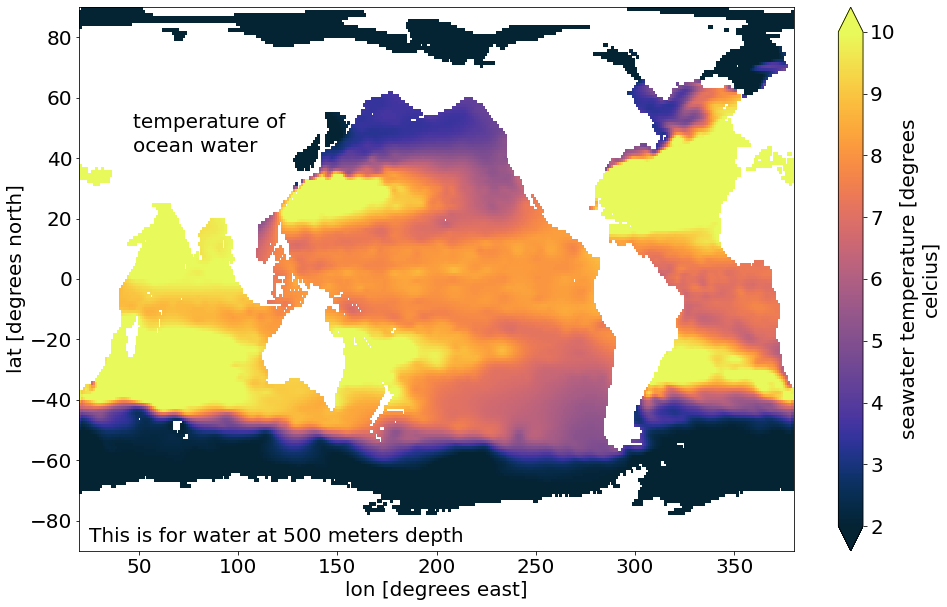

<function __main__.glodap_pTemp(depth_index)>

In [15]:
##########################
#
# glodap widget explorer: See what happens to each parameter with depth
#
##########################

# Usage notes
#   If this cell produces 'OSError: no files to open' you may need to run the data loader in the cell below. The
#   objective is to have the three NetCDF files resident in /data/glodap or in ~/data/glodap. See the comment
#   at the top of this file on two different Jupyterlab server cases. Also ensure data_dir is built correctly.
#
#   The slider for each image changes the depth of the data view. When a region becomes white: This is because the ocean does 
#     not go that deep in that location. This feature can be used to highlight the mid-oceanic ridges for example. 

glodapTemperatureFnm = data_dir + '/glodap/glodap_temperature.nc'
glodapSalinityFnm    = data_dir + '/glodap/glodap_salinity.nc'
glodapOxygenFnm      = data_dir + '/glodap/glodap_oxygen.nc'

glodap_dsSal  = xr.open_mfdataset(glodapSalinityFnm, combine='by_coords')
glodap_dsTemp = xr.open_mfdataset(glodapTemperatureFnm, combine='by_coords')
glodap_dsO2   = xr.open_mfdataset(glodapOxygenFnm, combine='by_coords')

plt.rcParams.update({'font.size': 20})

def glodap_pO2(depth_index):
    glodap_dsO2['oxygen'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.oxy,vmin=150, vmax=350)
    if depth_index == 0: msg = 'This is for surface water'
    else:                msg = 'This is for water at ' + str(int(glodap_dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(28, 50, 'oxygen dissolved in'); plt.text(28, 42, '     ocean water   ')

def glodap_pSal(depth_index):
    glodap_dsSal['salinity'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.haline,vmin=33, vmax=36)
    if depth_index == 0:msg = 'This is for surface water'
    else: msg = 'This is for water at ' + str(int(glodap_dsSal['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'salinity of'); plt.text(47, 42, 'ocean water')

def glodap_pTemp(depth_index):
    glodap_dsTemp['temperature'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.thermal,vmin=2., vmax=10.)
    if depth_index == 0: msg = 'This is for surface water'
    else: msg = 'This is for water at ' + str(int(glodap_dsTemp['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'temperature of'); plt.text(47, 42, 'ocean water')

interact(glodap_pO2,   depth_index=widgets.IntSlider(min=0, max=32, step=1, value=5,  continuous_update=False, description='depth'))
interact(glodap_pSal,  depth_index=widgets.IntSlider(min=0, max=32, step=1, value=0,  continuous_update=False, description='depth'))
interact(glodap_pTemp, depth_index=widgets.IntSlider(min=0, max=32, step=1, value=13, continuous_update=False, description='depth'))


In [10]:
#######################################################################################
#
# Data loader for Glodap data
# 
# This code block is commented out. It gets the three data files from object storage on
#   the AWS public cloud. The data may at some point be discontinued at that location
#   but it is openly available through the GLODAP website.
#
# 
# Citation: Lauvset, S. K., Key, R. M., Olsen, A., van Heuven, S., 
#   Velo, A., Lin, X., Schirnick, C., Kozyr, A., Tanhua, T., Hoppema, 
#   M., Jutterström, S., Steinfeldt, R., Jeansson, E., Ishii, M., 
#   Perez, F. F., Suzuki, T., and Watelet, S.: 
#   A new global interior ocean mapped climatology: the 1° ×  1° GLODAP 
#   version 2, Earth Syst. Sci. Data, 8, 325–340, 
#   https://doi.org/10.5194/essd-8-325-2016, 2016.
# 
#   from https://www.earth-syst-sci-data.net/8/325/2016/
#
# Open issue: Does this 2016 dataset supersede the World Ocean Atlas as described at
#   https://climatedataguide.ucar.edu/climate-data/world-ocean-atlas-2013-woa13?
#
#
# If necessary: Install the boto library
# !conda install boto -y
#
# This code copies data files from AWS Object Storage (S3) to the local directory

glodapTemperatureFnm = data_dir + '/glodap/glodap_temperature.nc'
glodapSalinityFnm    = data_dir + '/glodap/glodap_salinity.nc'
glodapOxygenFnm      = data_dir + '/glodap/glodap_oxygen.nc'

import boto
from boto.s3.key import Key

connection = boto.connect_s3(anon=True)
bucket = connection.get_bucket('himatdata')

for key in bucket.list(): 
    filename = key.name.encode('utf-8')
    if b'glodap' in filename: 
        if b'salinity.nc' in filename: 
            print ('salinity file is', filename)
            salinityfilename = filename
        if b'temperature.nc' in filename: 
            print ('temperature file is', filename)
            temperaturefilename = filename
        if b'oxygen.nc' in filename: 
            print('oxygen file is', filename)
            oxygenfilename = filename            

k = Key(bucket)
k.key = salinityfilename
k.get_contents_to_filename(glodapSalinityFnm)
k.key = temperaturefilename
k.get_contents_to_filename(glodapTemperatureFnm)
k.key = oxygenfilename
k.get_contents_to_filename(glodapOxygenFnm)

oxygen file is b'glodap/GLODAPv2.2016b.oxygen.nc'
salinity file is b'glodap/GLODAPv2.2016b.salinity.nc'
temperature file is b'glodap/GLODAPv2.2016b.temperature.nc'
